# Surface Salinity PCA & Explanation

After we have proved that salinity is a good tracer for total nitrate, including the part consumed by phytoplankton, we can now begin our analysis on surface salinity, which is a good indicator for both nitrate and see water movement.

## PCA 2011&2018 Summer

In order to make sure that our PCA will not mix different modes, I intend to conduct PCA on summers of 2011 and 2018 and check if they share PCs and Modes which have the same physical explanation.

In [1]:
# SSS_PCA_Comparison_2011_vs_2018.py
# Performs independent PCA on Sea Surface Salinity (SSS) for:
# 1. Summer 2011 (May 1 - Aug 31)
# 2. Summer 2018 (May 1 - Aug 31)
# And generates side-by-side comparison plots to check for consistency.

import netCDF4 as nc
import numpy as np
import datetime
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature 

# --- 1. Configuration ---

# !!! 请根据实际环境修改 !!!
BASE_DIR = '/results2/SalishSea/nowcast-green.201905/' 
FNAME_HEAD = 'SalishSea_1d_'
FNAME_TAIL = '_grid_T.nc' 

# 输出目录
OUT_DIR = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA/'
if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)
    print(f"Created output directory: {OUT_DIR}")

# 变量设置
VAR_SALINITY = 'vosaline'
VAR_LAT = 'nav_lat'
VAR_LON = 'nav_lon'

# 分析参数
YEARS_TO_COMPARE = [2011, 2018]
START_MONTH, START_DAY = 5, 1   # May 1st
END_MONTH, END_DAY = 8, 31      # Aug 31st

SPATIAL_SUBSAMPLE_STEP = 8 
N_COMPONENTS = 3  # 只对比前3个模态通常就够了

# --- 2. Data Loading Helper (Robust Land Masking) ---

def get_file_path(date_obj):
    indir_date = date_obj.strftime('%d%b%y').lower() + '/'
    fname_date = date_obj.strftime('%Y%m%d')
    return os.path.join(BASE_DIR, indir_date, FNAME_HEAD + fname_date + '_' + fname_date + FNAME_TAIL)

def load_daily_sss(date_obj, step):
    """
    Loads one day of SSS data.
    Returns: (sss_flat_clean, lon_2d, lat_2d, valid_mask_1d)
    """
    fpath = get_file_path(date_obj)
    if not os.path.exists(fpath):
        return None, None, None, None
    
    try:
        with nc.Dataset(fpath, 'r') as ncfile:
            sss = ncfile.variables[VAR_SALINITY][0, 0, ::step, ::step]
            lon = ncfile.variables[VAR_LON][::step, ::step]
            lat = ncfile.variables[VAR_LAT][::step, ::step]
            
            # Masking: Lon != 0 AND SSS is not NaN
            mask_valid = (lon != 0.0) & (~np.isnan(sss)) & (sss < 1000) # Simple range check
            
            # Flatten everything
            sss_flat = sss.flatten()
            mask_flat = mask_valid.flatten()
            
            # Apply mask
            sss_clean = sss_flat[mask_flat]
            
            return sss_clean, lon, lat, mask_flat
    except Exception as e:
        print(f"Error loading {date_obj}: {e}")
        return None, None, None, None

# --- 3. Single Year Analysis Engine ---

def analyze_year(year):
    """
    Runs PCA for a single year's summer period.
    Returns a dictionary with all results needed for plotting.
    """
    print(f"\n--- Analyzing Year {year} (May 1 - Aug 31) ---")
    start_date = datetime.date(year, START_MONTH, START_DAY)
    end_date = datetime.date(year, END_MONTH, END_DAY)
    
    data_list = []
    dates_list = []
    
    # Static grid info (captured from first valid day)
    grid_lon, grid_lat, grid_mask = None, None, None
    original_shape = None

    curr = start_date
    while curr <= end_date:
        vec, lon, lat, mask = load_daily_sss(curr, SPATIAL_SUBSAMPLE_STEP)
        if vec is not None:
            if grid_lon is None:
                grid_lon, grid_lat, grid_mask = lon, lat, mask
                original_shape = lon.shape
            
            # Consistency check
            if vec.shape[0] != grid_mask.sum():
                print(f"  Skipping {curr}: Grid mismatch (Mask len {grid_mask.sum()} vs Data {vec.shape[0]})")
            else:
                data_list.append(vec)
                dates_list.append(curr)
        curr += datetime.timedelta(days=1)
        
    if not data_list:
        return None
    
    # PCA Execution
    X = np.array(data_list)
    print(f"  Data shape: {X.shape}")
    
    pca = PCA(n_components=N_COMPONENTS)
    # Fit on centered data
    pcs = pca.fit_transform(X - X.mean(axis=0)) 
    eofs = pca.components_
    var_ratio = pca.explained_variance_ratio_
    
    # --- Auto-Flip Signs for Consistency ---
    # PCA signs are arbitrary. We flip them so the maximum absolute value is always positive.
    # This makes comparing maps between years much easier.
    for i in range(N_COMPONENTS):
        max_idx = np.argmax(np.abs(eofs[i]))
        if eofs[i][max_idx] < 0:
            eofs[i] *= -1
            pcs[:, i] *= -1 # Must flip PC time series too!
            
    return {
        'year': year,
        'pcs': pcs, # (Time, Modes)
        'eofs': eofs, # (Modes, Space)
        'var': var_ratio,
        'dates': dates_list,
        'lon': grid_lon,
        'lat': grid_lat,
        'mask': grid_mask,
        'shape': original_shape
    }

# --- 4. Comparison Plotting Functions ---

def plot_side_by_side_spatial(res1, res2, mode_idx):
    """Plots the Spatial Mode (EOF) of Year 1 and Year 2 side by side."""
    
    fig = plt.figure(figsize=(14, 7))
    
    # Shared settings
    extent = [-125.5, -122, 48, 50.5]
    levels = np.linspace(-0.15, 0.15, 41) # Fixed scale for easier comparison!
    # Note: You might need to adjust levels if EOF values are very small/large
    
    results_list = [res1, res2]
    
    for k in range(2):
        res = results_list[k]
        ax = fig.add_subplot(1, 2, k+1, projection=ccrs.Mercator(central_longitude=-124))
        ax.set_extent(extent, crs=ccrs.PlateCarree())
        
        # Reconstruct 2D field
        eof_1d = res['eofs'][mode_idx]
        eof_2d_flat = np.full(res['mask'].shape, np.nan)
        eof_2d_flat[res['mask']] = eof_1d
        eof_2d = eof_2d_flat.reshape(res['shape'])
        
        # Adaptive Color Limits (override fixed levels if needed)
        limit = np.nanmax(np.abs(eof_2d))
        current_levels = np.linspace(-limit, limit, 40)
        
        cf = ax.contourf(res['lon'], res['lat'], eof_2d, 
                         levels=current_levels, cmap='RdBu_r', 
                         transform=ccrs.PlateCarree(), extend='both')
        
        ax.add_feature(cfeature.LAND, color='lightgray', zorder=2)
        ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=3)
        
        ax.set_title(f"{res['year']} EOF-{mode_idx+1}\n(Explains {res['var'][mode_idx]*100:.1f}%)", fontsize=14)
        plt.colorbar(cf, ax=ax, shrink=0.8, orientation='horizontal', pad=0.05)

    plt.suptitle(f"Comparison of Spatial Mode {mode_idx+1} (Summer)", fontsize=16)
    
    save_path = os.path.join(OUT_DIR, f"Compare_Spatial_Mode_{mode_idx+1}.png")
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()
    print(f"Saved comparison map: {save_path}")

def plot_overlaid_timeseries(res1, res2, mode_idx):
    """Plots PC time series overlaid on a Day-of-Year axis."""
    
    plt.figure(figsize=(12, 4))
    
    # Helper to get day of year
    def get_doy(dates):
        return [d.timetuple().tm_yday for d in dates]
    
    doy1 = get_doy(res1['dates'])
    pc1 = res1['pcs'][:, mode_idx]
    
    doy2 = get_doy(res2['dates'])
    pc2 = res2['pcs'][:, mode_idx]
    
    plt.plot(doy1, pc1, 'r-', lw=2, alpha=0.8, label=f"{res1['year']} (Var: {res1['var'][mode_idx]*100:.1f}%)")
    plt.plot(doy2, pc2, 'b--', lw=2, alpha=0.8, label=f"{res2['year']} (Var: {res2['var'][mode_idx]*100:.1f}%)")
    
    plt.xlabel("Day of Year (May 1 is approx Day 121)")
    plt.ylabel("PC Amplitude")
    plt.title(f"PC-{mode_idx+1} Time Series Comparison")
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.legend()
    
    save_path = os.path.join(OUT_DIR, f"Compare_TimeSeries_PC_{mode_idx+1}.svg")
    plt.savefig(save_path, bbox_inches='tight', dpi=150)
    plt.close()
    print(f"Saved comparison TS: {save_path}")

# --- 5. Main Execution ---

if __name__ == "__main__":
    # 1. Analyze 2011
    res_2011 = analyze_year(2011)
    
    # 2. Analyze 2018
    res_2018 = analyze_year(2018)
    
    if res_2011 and res_2018:
        print("\n--- Generating Comparison Plots ---")
        
        # Compare first 3 modes
        for i in range(N_COMPONENTS):
            # A. Spatial Comparison
            plot_side_by_side_spatial(res_2011, res_2018, mode_idx=i)
            
            # B. Time Series Comparison
            plot_overlaid_timeseries(res_2011, res_2018, mode_idx=i)
            
        print(f"\nDone! Check folder: {OUT_DIR}")
        print("Tip: If EOF-1 maps look similar (e.g., both river plume patterns), you can safely combine years.")
    else:
        print("Error: Could not process both years successfully.")


--- Analyzing Year 2011 (May 1 - Aug 31) ---
  Data shape: (123, 2880)

--- Analyzing Year 2018 (May 1 - Aug 31) ---
  Data shape: (123, 2880)

--- Generating Comparison Plots ---
Saved comparison map: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA/Compare_Spatial_Mode_1.png
Saved comparison TS: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA/Compare_TimeSeries_PC_1.svg
Saved comparison map: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA/Compare_Spatial_Mode_2.png
Saved comparison TS: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA/Compare_TimeSeries_PC_2.svg
Saved comparison map: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA/Compare_Spatial_Mode_3.png
Saved comparison TS: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA/Compare_TimeSeries_PC_3.svg

Done! Ch

The 2 yr case was a little weird. Mode 2 can be explained as Wind-Driven Plume Steering, or the turning of Fraser Plume caused by wind. Mode 3 was explained as Cross-Channel / Upwelling. We can use 10yr-summer daily data to verify it.

## PCA on 10-year Summers (2010-2019)

In [2]:
# SSS_PCA_Decade_Calc.py
# 1. Loads SSS for Summer (May 1 - Aug 31) from 2010 to 2019.
# 2. Performs PCA (EOF analysis).
# 3. Saves PCs to CSV and all matrices to .npz for fast plotting.

import netCDF4 as nc
import numpy as np
import datetime
import os
import pandas as pd
from sklearn.decomposition import PCA

# --- Configuration ---
# !!! 修改路径 !!!
BASE_DIR = '/results2/SalishSea/nowcast-green.201905/' 
FNAME_HEAD = 'SalishSea_1d_'
FNAME_TAIL = '_grid_T.nc' 
OUT_DIR = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA_10yr/'

if not os.path.exists(OUT_DIR):
    os.makedirs(OUT_DIR)

# 时间范围: 2010-2019, 每年 5.1 - 8.31
YEARS = range(2010, 2020) 
START_MD = (5, 1)
END_MD = (8, 31)

SPATIAL_STEP = 8  # 空间降采样步长
N_MODES = 6       #哪怕你只看前3个，算的时候多存几个没坏处

# --- Helper Functions ---
def get_file_path(date_obj):
    indir = date_obj.strftime('%d%b%y').lower() + '/'
    fname = date_obj.strftime('%Y%m%d')
    return os.path.join(BASE_DIR, indir, FNAME_HEAD + fname + '_' + fname + FNAME_TAIL)

def load_daily_sss(date_obj, step):
    """Loads, subsamples, and cleans one day of data."""
    path = get_file_path(date_obj)
    if not os.path.exists(path):
        return None, None, None, None
    try:
        with nc.Dataset(path, 'r') as f:
            # Load SSS (Time=0, Depth=0)
            sss = f.variables['vosaline'][0, 0, ::step, ::step]
            lon = f.variables['nav_lon'][::step, ::step]
            lat = f.variables['nav_lat'][::step, ::step]
            
            # Masking: Remove (0,0) artifacts and NaNs
            # SalishSeaCast model uses 0 for land in coords sometimes, or masked arrays
            mask = (lon != 0) & (~np.isnan(sss)) & (sss < 100) # Simple validity check
            
            return sss.flatten()[mask.flatten()], lon, lat, mask.flatten()
    except:
        return None, None, None, None

# --- Main Processing ---
if __name__ == "__main__":
    print(f"=== Starting Decade Analysis (2010-2019) ===")
    
    data_matrix = []
    time_index = []
    
    # Grid metadata (captured from the first valid file)
    grid_lon, grid_lat, grid_mask = None, None, None
    original_shape = None
    
    # 1. Loop through all dates
    for year in YEARS:
        d_start = datetime.date(year, *START_MD)
        d_end = datetime.date(year, *END_MD)
        curr = d_start
        print(f"  Loading year {year}...", end='\r')
        
        while curr <= d_end:
            vec, lon, lat, mask = load_daily_sss(curr, SPATIAL_STEP)
            
            if vec is not None:
                if grid_lon is None:
                    grid_lon, grid_lat, grid_mask = lon, lat, mask
                    original_shape = lon.shape
                
                # Double check grid consistency
                if len(vec) == grid_mask.sum():
                    data_matrix.append(vec)
                    time_index.append(curr)
            
            curr += datetime.timedelta(days=1)
    
    print(f"\nData Loading Done. Total Samples: {len(data_matrix)}")
    
    # 2. PCA Calculation
    X = np.array(data_matrix)
    print(f"Matrix Shape: {X.shape}")
    
    # De-mean (Anomaly)
    X_mean = X.mean(axis=0)
    X_anom = X - X_mean
    
    print("Computing PCA...")
    pca = PCA(n_components=N_MODES)
    PCs = pca.fit_transform(X_anom)   # (Time, Modes)
    EOFs = pca.components_            # (Modes, Space)
    Var = pca.explained_variance_ratio_
    
    # --- Sign Correction (Important for 10-year consistency) ---
    # Ensure the maximum amplitude of the spatial pattern is positive
    print("Standardizing signs...")
    for i in range(N_MODES):
        max_idx = np.argmax(np.abs(EOFs[i]))
        if EOFs[i][max_idx] < 0:
            EOFs[i] *= -1
            PCs[:, i] *= -1
            
    # 3. Saving Results
    
    # A. Save Time Series to CSV (User Request)
    print("Saving CSV...")
    df_pcs = pd.DataFrame(PCs, columns=[f'PC_{i+1}' for i in range(N_MODES)])
    df_pcs['Date'] = time_index
    df_pcs['Year'] = [d.year for d in time_index]
    df_pcs['DOY'] = [d.timetuple().tm_yday for d in time_index] # Day of Year
    
    csv_path = os.path.join(OUT_DIR, 'PCA_Decade_TimeSeries_2010_2019.csv')
    df_pcs.to_csv(csv_path, index=False)
    
    # B. Save Matrices for Plotting (Pickle/Numpy)
    # This saves EVERYTHING needed to reconstruct the plots without raw data
    npy_path = os.path.join(OUT_DIR, 'PCA_Decade_Spatial_Data.npz')
    np.savez(npy_path, 
             eofs=EOFs, 
             variance=Var, 
             lon=grid_lon, 
             lat=grid_lat, 
             mask=grid_mask, 
             shape=original_shape,
             mean_state=X_mean)
    
    print(f"SUCCESS!\nCSV saved to: {csv_path}\nPlotting Data saved to: {npy_path}")

=== Starting Decade Analysis (2010-2019) ===
  Loading year 2019...
Data Loading Done. Total Samples: 1230
Matrix Shape: (1230, 2880)
Computing PCA...
Standardizing signs...
Saving CSV...
SUCCESS!
CSV saved to: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA_10yr/PCA_Decade_TimeSeries_2010_2019.csv
Plotting Data saved to: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA_10yr/PCA_Decade_Spatial_Data.npz


In [4]:
# SSS_PCA_Decade_Plot.py
# Reads the pre-calculated PCA results and generates high-quality plots.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os

# --- Config ---
# 指向第一步生成的目录
IN_DIR = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA_10yr/'

CSV_PATH = os.path.join(IN_DIR, 'PCA_Decade_TimeSeries_2010_2019.csv')
NPY_PATH = os.path.join(IN_DIR, 'PCA_Decade_Spatial_Data.npz')

# --- 1. Load Data ---
print("Loading pre-computed data...")
data = np.load(NPY_PATH, allow_pickle=True)
df_pcs = pd.read_csv(CSV_PATH, parse_dates=['Date'])

eofs = data['eofs']
var_ratio = data['variance']
lon = data['lon']
lat = data['lat']
mask = data['mask']     # 1D boolean mask
grid_shape = data['shape'] # Original 2D shape (y, x)

# --- 2. Plotting Functions ---

def plot_spatial_mode(mode_idx):
    """Plots the 2D spatial pattern of a specific mode."""
    # Reconstruct 2D Field from 1D clean vector
    eof_1d = eofs[mode_idx]
    
    # Create full grid filled with NaNs
    full_field = np.full(mask.shape, np.nan)
    # Fill in valid points
    full_field[mask] = eof_1d
    # Reshape to 2D
    eof_2d = full_field.reshape(grid_shape)
    
    # Plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator(central_longitude=-124))
    ax.set_extent([-125.5, -122, 48, 50.5], crs=ccrs.PlateCarree())
    
    # Adaptive Color Limits (Symmetric)
    limit = np.nanmax(np.abs(eof_2d))
    levels = np.linspace(-limit, limit, 41)
    
    cf = ax.contourf(lon, lat, eof_2d, levels=levels, cmap='RdBu_r', 
                     transform=ccrs.PlateCarree(), extend='both')
    
    ax.add_feature(cfeature.LAND, color='lightgray', zorder=2)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.8, zorder=3)
    ax.add_feature(cfeature.BORDERS, linestyle=':', zorder=3)
    
    cbar = plt.colorbar(cf, ax=ax, shrink=0.7, pad=0.05)
    cbar.set_label('EOF Amplitude')
    
    title = f"Mode {mode_idx+1} Spatial Pattern (Explains {var_ratio[mode_idx]*100:.1f}%)"
    ax.set_title(title, fontsize=14)
    
    save_name = os.path.join(IN_DIR, f'Decade_EOF_Mode_{mode_idx+1}.svg')
    plt.savefig(save_name, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Saved Map: {save_name}")

def plot_time_series_10years(mode_idx):
    """Plots the full 10-year time series."""
    pc_col = f'PC_{mode_idx+1}'
    
    plt.figure(figsize=(15, 4))
    
    # Plot the line
    plt.plot(df_pcs['Date'], df_pcs[pc_col], 'k-', linewidth=0.8, alpha=0.8)
    
    # Highlight 2011 and 2018 (Your specific interest)
    # Masking for colors
    subset_2011 = df_pcs[df_pcs['Year'] == 2011]
    plt.plot(subset_2011['Date'], subset_2011[pc_col], 'r-', linewidth=1.5, label='2011 (Wet/High Flow)')
    
    subset_2018 = df_pcs[df_pcs['Year'] == 2018]
    plt.plot(subset_2018['Date'], subset_2018[pc_col], 'b-', linewidth=1.5, label='2018 (Dry/Low Flow)')
    
    plt.ylabel('PC Amplitude')
    plt.title(f"Mode {mode_idx+1} Time Series (2010-2019)", fontsize=14)
    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend()
    
    save_name = os.path.join(IN_DIR, f'Decade_PC_{mode_idx+1}_TimeSeries.svg')
    plt.savefig(save_name, dpi=200, bbox_inches='tight')
    plt.close()
    print(f"Saved TS: {save_name}")

def plot_doy_overlay(mode_idx):
    """Overlays all years on a Day-of-Year axis to see seasonal consistency."""
    pc_col = f'PC_{mode_idx+1}'
    
    plt.figure(figsize=(12, 5))
    
    # Plot background years (Gray)
    for year in df_pcs['Year'].unique():
        subset = df_pcs[df_pcs['Year'] == year]
        if year not in [2011, 2018]:
            plt.plot(subset['DOY'], subset[pc_col], color='gray', alpha=0.3, linewidth=1)
            
    # Highlight specific years
    s2011 = df_pcs[df_pcs['Year'] == 2011]
    plt.plot(s2011['DOY'], s2011[pc_col], 'r-', linewidth=2, label='2011')
    
    s2018 = df_pcs[df_pcs['Year'] == 2018]
    plt.plot(s2018['DOY'], s2018[pc_col], 'b--', linewidth=2, label='2018')
    
    plt.xlabel('Day of Year')
    plt.ylabel('PC Amplitude')
    plt.title(f"Mode {mode_idx+1}: Seasonal Variability (Overlaid)", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.5)
    
    save_name = os.path.join(IN_DIR, f'Decade_PC_{mode_idx+1}_Seasonality.svg')
    plt.savefig(save_name, dpi=200, bbox_inches='tight')
    plt.close()
    print(f"Saved Seasonal Plot: {save_name}")

# --- 3. Execute Plotting ---
if __name__ == "__main__":
    # Plot top 3 modes
    for i in range(3):
        print(f"--- Plotting Mode {i+1} ---")
        plot_spatial_mode(i)
        plot_time_series_10years(i)
        plot_doy_overlay(i)
        
    print("All plots generated.")

Loading pre-computed data...
--- Plotting Mode 1 ---
Saved Map: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA_10yr/Decade_EOF_Mode_1.svg
Saved TS: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA_10yr/Decade_PC_1_TimeSeries.svg
Saved Seasonal Plot: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA_10yr/Decade_PC_1_Seasonality.svg
--- Plotting Mode 2 ---
Saved Map: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA_10yr/Decade_EOF_Mode_2.svg
Saved TS: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA_10yr/Decade_PC_2_TimeSeries.svg
Saved Seasonal Plot: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA_10yr/Decade_PC_2_Seasonality.svg
--- Plotting Mode 3 ---
Saved Map: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Results_PCA_10yr/Decade_EOF_Mo

### Method Script

In detail, we can say:

To investigate the spatiotemporal variability of the Fraser River plume and its response to wind forcing, we performed an Empirical Orthogonal Function (EOF) analysis, also known as Principal Component Analysis (PCA), on the model-simulated Sea Surface Salinity (SSS) fields.

The analysis utilizes daily-averaged SSS output from the SalishSeaCast model (version 201905) covering a ten-year period from 2010 to 2019. For each year, we extracted data for the extended summer season, defined as May 1st to August 31st, to capture the full progression of the Fraser River freshet and the dominant summer wind patterns.

Data Preprocessing: To focus on synoptic-scale variability (e.g., wind-driven plume advection) while filtering out high-frequency tidal oscillations, daily averaged fields were selected. Spatially, the model grid was subsampled by a factor of 8 in both zonal and meridional directions to reduce computational cost while preserving mesoscale features. Land points and model boundary artifacts were masked out.

PCA Decomposition: The 3D SSS data (time, latitude, longitude) were flattened into a 2D matrix X(t,s), where t represents the daily time steps (N=1230 days total) and s represents the spatial grid points. The temporal mean at each grid point was subtracted to obtain the SSS anomaly field X 
′
 . The PCA was then performed on the covariance matrix of X 
′
 to decompose the variability into orthogonal spatial modes (EOFs) and their corresponding temporal coefficients (Principal Components, PCs).

The first few modes were retained for analysis, as they represent the dominant coherent patterns of salinity variability in the Salish Sea. The sign of the EOFs was standardized such that the maximum absolute amplitude is positive, ensuring consistency across different modes.

But for short:

Principal Component Analysis (PCA) of Summer SSS (2010–2019). We applied PCA to daily-averaged Sea Surface Salinity (SSS) anomalies from the SalishSeaCast model to identify dominant spatiotemporal patterns. The dataset covers the summer months (May 1 – Aug 31) over a decadal period (2010–2019). Daily averages were used to resolve synoptic wind events while removing tidal signals. The spatial grid was subsampled by a factor of 8. The data were centered by subtracting the long-term mean prior to decomposition. The resulting spatial modes (EOFs) and time series (PCs) describe the deviation of the plume structure from the mean state.

### Results Script

Results: Spatiotemporal Variability of Summer Sea Surface Salinity

The Principal Component Analysis (PCA) applied to the daily sea surface salinity (SSS) anomalies for the summers (May–August) of 2010–2019 reveals three dominant modes of variability. Together, these three modes explain approximately 67.5% of the total variance in the SSS field, capturing the primary drivers of the salinity structure in the Salish Sea: river discharge volume, wind-driven redistribution, and plume dispersion dynamics.

1. The Seasonal Discharge Mode (EOF1)

The first mode (EOF1) is the dominant component, accounting for 47.7% of the total variance (Fig. Xa). Spatially, this mode exhibits a coherent, monopole structure across the entire Strait of Georgia, with the highest amplitudes centered near the Fraser River mouth and extending into the central basin. The uniform sign of the spatial coefficients indicates that SSS variations associated with this mode occur in phase across the entire domain.

Physically, EOF1 represents the seasonal accumulation and draining of the total freshwater volume within the Strait. It captures the primary response to the Fraser River freshet: a strong positive phase in the associated Principal Component (PC1) corresponds to periods of high river discharge, resulting in a widespread freshening of the surface layer. Conversely, negative phases correspond to periods of reduced discharge or increased salinity prior to the freshet peak. This mode serves as a proxy for the total freshwater budget of the system.

2. The Wind-Driven Upwelling-Advection Dipole (EOF2)

The second mode (EOF2) explains 13.6% of the variance and reveals a distinct north-south dipole structure (Fig. Xb). The zero-crossing line (nodal line) is situated approximately near the Fraser River mouth, separating the domain into northern and southern sub-basins with opposing salinity anomalies.

Notably, the spatial morphology of this mode suggests a spatially coupled hydrodynamic response to the prevailing along-strait winds:

In the Northern Strait: The spatial pattern is boundary-intensified, with strong anomalies concentrated along the eastern and western shallow margins (e.g., Texada Island and Malaspina Strait). This structure is consistent with wind-driven coastal upwelling, where northwesterly winds drive surface Ekman transport, inducing the upwelling of saline deep water along the boundaries.

In the Southern Strait: The pattern is characterized by a broad, basin-wide anomaly extending towards the Gulf Islands and Boundary Pass. This reflects the meridional advection of the stratified Fraser River plume.

Under typical summer conditions (northwesterly winds), this mode manifests as a southward extension of the fresh plume (freshening the south) coupled with upwelling-favorable conditions in the north (increasing salinity). During reversal events (southeasterly winds), the pattern inverts, pushing the plume northward and suppressing the northern upwelling.

3. The Plume Dispersion Mode (EOF3)

The third mode (EOF3) accounts for 6.2% of the variance and captures a cross-channel contrast (Fig. Xc). The spatial pattern highlights a dynamic opposition between the "near-field" region (immediate vicinity of the river mouth and southern tidal channels) and the "far-field" region (central Strait and northern basin).

This mode represents the variability in plume retention versus dispersion. A positive phase (as shown in Fig. Xc, red near the mouth) indicates conditions where freshwater is confined close to the delta or trapped along the coast, likely due to weak mixing or specific tidal phases. A negative phase (blue near the mouth) suggests enhanced cross-channel spreading and effective mixing of freshwater into the ambient central basin. While explaining a smaller fraction of the total variance, this mode is significant for understanding the distinct plume geometry independent of the total discharge volume or wind direction.

Mode 1 (单极子): 

这是一个整体性的变化，不是哪里多了哪里少了，而是整个池子水变淡了或变咸了。这是为了对应 Fraser River 的总流量。

Mode 2: 

"spatially coupled hydrodynamic response"（空间耦合的水动力响应）。

North: "boundary-intensified"（边界强化）和 "consistent with wind-driven coastal upwelling"。“海峡两岸变色”的现象，暗示了涌升流机制。

South:  "meridional advection"（经向平流）。**(We will change the phase)** “一团水被推着走”的现象。

因为北方是 Upwelling 主导，所以营养盐主要由这个物理过程控制……

Mode 3 (扩散/滞留)：

"near-field vs. far-field"（近场 vs 远场）

解释为什么河口和海峡中间颜色相反。代表水是“堆在门口”还是“散开了”。

## Mode Explanation

We have good reasons to believe that the explanations for modes above are correct! But we do still need to verify them.

In [1]:
# Daily WindSpeed along Strait of Georgia (2010-2019)

import pandas as pd
import numpy as np
import os

# ================= 配置区域 =================
# 输入数据路径 (Sand Heads 气象站)
DIR_WIND = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Data_SandHead'

# 输出路径
OUTPUT_DIR = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Data_PCs/'
OUTPUT_FILENAME = 'Summer_Daily_AlongStrait_Wind_2010-2019.csv'

# 时间范围
START_YEAR = 2010
END_YEAR = 2019
SUMMER_MONTHS = [6, 7, 8, 9]  # 6月到9月底

# 沿海峡轴向定义 (来自哪个方向的风为正)
# 135度 = 东南风 (SE)。
# 既然是 Strait of Georgia，通常 NW-SE 走向。
# 这里设定：来自 135° (SE) 的分量为正，来自 315° (NW) 的分量为负。
AXIS_FROM_DEG = 135 
# ===========================================

def process_daily_wind():
    all_data = []
    
    # Environment Canada CSV 列名定义
    col_date = 'Date/Time'
    col_dir = 'Dir of Max Gust (10s deg)' # 注意：有的文件可能是 'Dir of Max Gust (10s deg)' 或 'Dir of Max Gust'
    col_spd = 'Spd of Max Gust (km/h)'    # 同上，需确保列名匹配

    print(f"开始处理 {START_YEAR} - {END_YEAR} 年的夏季数据 (6-9月)...")

    for year in range(START_YEAR, END_YEAR + 1):
        # 构建文件名，假设命名格式如下
        file_name = f'en_climate_daily_BC_1107010_{year}_P1D.csv'
        file_path = os.path.join(DIR_WIND, file_name)
        
        if not os.path.exists(file_path):
            print(f"警告: 文件未找到 {file_path}")
            continue
            
        try:
            # 读取数据
            df = pd.read_csv(file_path)
            
            # 简单的列名检查/清理，防止列名带空格
            df.columns = df.columns.str.strip()
            
            # 确保需要的列存在
            if col_dir not in df.columns or col_spd not in df.columns:
                print(f"警告: {year}年数据缺少风速或风向列，跳过。")
                continue

            # 提取需要的列
            df = df[[col_date, col_dir, col_spd]].copy()
            df[col_date] = pd.to_datetime(df[col_date])
            
            # 1. 筛选夏季 (6, 7, 8, 9月)
            df = df[df[col_date].dt.month.isin(SUMMER_MONTHS)].copy()
            
            # 2. 数据清洗
            df[col_dir] = pd.to_numeric(df[col_dir], errors='coerce')
            df[col_spd] = pd.to_numeric(df[col_spd], errors='coerce')
            
            # 去除空值
            df.dropna(subset=[col_dir, col_spd], inplace=True)
            
            if df.empty:
                print(f"{year}年夏季无有效数据。")
                continue

            # 3. 投影计算 (沿海峡方向)
            # 原始数据是 10s deg，所以要乘 10
            wind_dir_deg = df[col_dir] * 10
            
            # 转换为弧度
            # 计算公式：Speed * cos(Wind_Dir - Axis)
            # 结果含义：
            #   正值 (+): 风来自 SE 方向 (Downwelling-favorable / Inflow)
            #   负值 (-): 风来自 NW 方向 (Upwelling-favorable / Outflow)
            radians = np.deg2rad(wind_dir_deg - AXIS_FROM_DEG)
            
            # 注意：这里去掉了 .abs()，保留方向性！
            df['Along_Strait_Wind'] = df[col_spd] * np.cos(radians)
            
            # 添加年份标记，方便后续索引
            df['Year'] = df[col_date].dt.year
            df['Month'] = df[col_date].dt.month
            df['Day'] = df[col_date].dt.day
            
            # 保存需要的字段
            all_data.append(df[[col_date, 'Year', 'Month', 'Day', 'Along_Strait_Wind']])
            
        except Exception as e:
            print(f"处理 {year} 年数据时出错: {e}")

    if not all_data:
        print("未提取到任何数据。")
        return

    # 合并所有年份数据
    final_df = pd.concat(all_data, ignore_index=True)
    
    # 按时间排序
    final_df.sort_values(by=col_date, inplace=True)
    
    # 确保输出目录存在
    if not os.path.exists(OUTPUT_DIR):
        os.makedirs(OUTPUT_DIR)
        print(f"创建目录: {OUTPUT_DIR}")

    # 保存 CSV
    output_path = os.path.join(OUTPUT_DIR, OUTPUT_FILENAME)
    final_df.to_csv(output_path, index=False)
    
    print("-" * 30)
    print(f"处理完成！")
    print(f"总天数: {len(final_df)}")
    print(f"数据已保存至: {output_path}")
    print("数据说明: Along_Strait_Wind 正值代表偏东南风(SE)，负值代表偏西北风(NW)。")

if __name__ == "__main__":
    process_daily_wind()

开始处理 2010 - 2019 年的夏季数据 (6-9月)...
------------------------------
处理完成！
总天数: 705
数据已保存至: /home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Data_PCs/Summer_Daily_AlongStrait_Wind_2010-2019.csv
数据说明: Along_Strait_Wind 正值代表偏东南风(SE)，负值代表偏西北风(NW)。


正在加载数据...
合并后有效数据天数: 525
图片已保存至: PC_Correlation_Analysis_NoSeaborn.svg


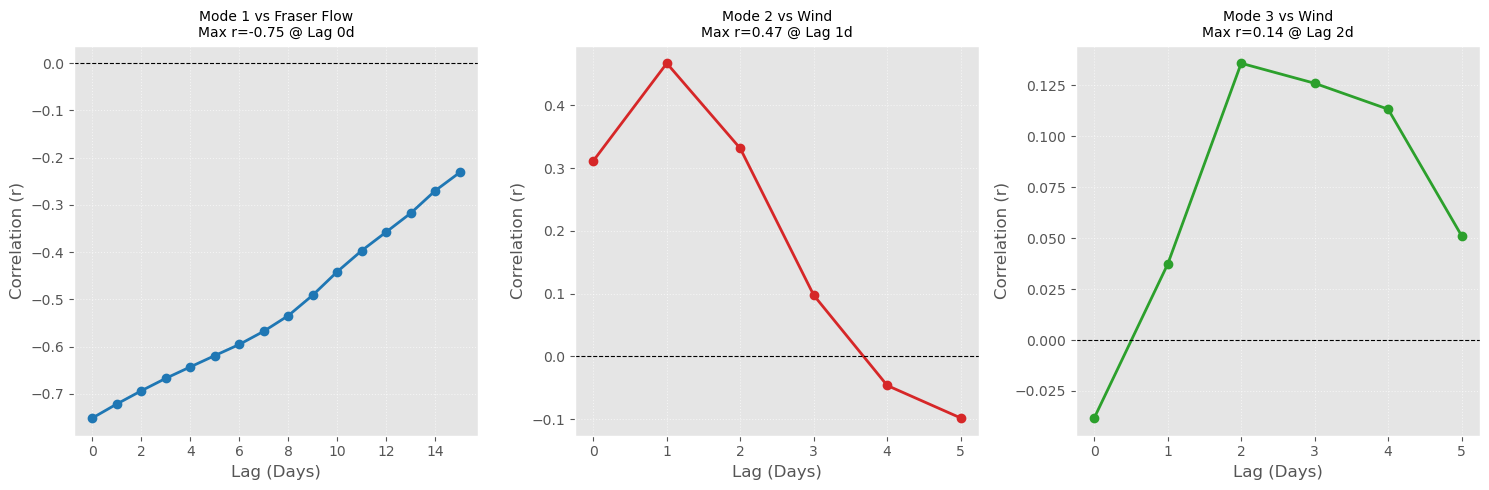

In [4]:
# Correlation Analysis between Fraser River Flow, PCA Modes, and Along-Strait Wind

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# ==================== 1. 文件路径配置 ====================
# 请检查你的路径是否正确
PATH_FLOW = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Data_PCs/Fraser_flow'
PATH_PC   = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Data_PCs/PCA_Decade_TimeSeries_2010_2019.csv'
PATH_WIND = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Data_PCs/Summer_Daily_AlongStrait_Wind_2010-2019.csv'

SUMMER_MONTHS = [6, 7, 8, 9]

# ==================== 2. 数据读取函数 ====================

def load_fraser_flow(filepath):
    """
    读取 Fraser River 流量数据
    格式: Year Month Day Flow (空格分隔，允许行尾有 # 注释)
    """
    try:
        # 修改点在这里：加入了 comment='#'
        df = pd.read_csv(
            filepath, 
            sep=r'\s+', 
            header=None, 
            names=['Year', 'Month', 'Day', 'Flow'],
            comment='#'  # <--- 关键！遇到 # 就忽略后面的内容
        )
        
        # 转换日期
        df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
        return df[['Date', 'Flow']].set_index('Date')
        
    except Exception as e:
        print(f"Error loading Fraser Flow: {e}")
        # 如果还是报错，打印出前几行看看是不是别的格式问题
        try:
            with open(filepath, 'r') as f:
                print("File head context:", [next(f) for _ in range(3)])
        except:
            pass
        return None

def load_pcs(filepath):
    try:
        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        return df[['Date', 'PC_1', 'PC_2', 'PC_3']].set_index('Date')
    except Exception as e:
        print(f"Error loading PCs: {e}")
        return None

def load_wind(filepath):
    try:
        df = pd.read_csv(filepath)
        date_col = 'Date/Time' if 'Date/Time' in df.columns else 'Date'
        df['Date'] = pd.to_datetime(df[date_col])
        return df[['Date', 'Along_Strait_Wind']].set_index('Date')
    except Exception as e:
        print(f"Error loading Wind: {e}")
        return None

# ==================== 3. 主分析逻辑 ====================

def calculate_lagged_correlation(series_driver, series_response, max_lag=10):
    lags = list(range(0, max_lag + 1))
    corrs = []
    
    for lag in lags:
        # Driver(t-lag) vs Response(t)
        if len(series_driver) > lag:
            # Shift driver down by lag
            shifted_driver = series_driver.shift(lag)
            r = shifted_driver.corr(series_response)
            corrs.append(r)
        else:
            corrs.append(np.nan)
        
    return lags, corrs

def main():
    print("正在加载数据...")
    df_flow = load_fraser_flow(PATH_FLOW)
    df_pcs  = load_pcs(PATH_PC)
    df_wind = load_wind(PATH_WIND)
    
    if df_flow is None or df_pcs is None or df_wind is None:
        print("数据加载失败，请检查路径。")
        return

    # 合并数据
    df_merged = df_pcs.join(df_wind, how='inner').join(df_flow, how='inner')
    df_merged = df_merged[df_merged.index.month.isin(SUMMER_MONTHS)]
    
    print(f"合并后有效数据天数: {len(df_merged)}")

    # 计算相关性
    MAX_LAG_FLOW = 15
    MAX_LAG_WIND = 5

    results = {}
    results['PC1_vs_Flow'] = calculate_lagged_correlation(df_merged['Flow'], df_merged['PC_1'], MAX_LAG_FLOW)
    results['PC2_vs_Wind'] = calculate_lagged_correlation(df_merged['Along_Strait_Wind'], df_merged['PC_2'], MAX_LAG_WIND)
    results['PC3_vs_Wind'] = calculate_lagged_correlation(df_merged['Along_Strait_Wind'], df_merged['PC_3'], MAX_LAG_WIND)
    
    # ==================== 4. 绘图 (纯 Matplotlib 版) ====================
    # 使用 ggplot 样式，这是 matplotlib 自带的，比默认的好看，不需要额外安装任何东西
    plt.style.use('ggplot') 
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 辅助画图函数
    def plot_corr(ax, res, title, color):
        lags, corrs = res
        # 找到绝对值最大的相关系数
        max_idx = np.argmax(np.abs(corrs))
        max_r = corrs[max_idx]
        best_lag = lags[max_idx]
        
        ax.plot(lags, corrs, marker='o', color=color, linewidth=2)
        ax.set_title(f'{title}\nMax r={max_r:.2f} @ Lag {best_lag}d', fontsize=10)
        ax.set_xlabel('Lag (Days)')
        ax.set_ylabel('Correlation (r)')
        ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
        ax.grid(True, linestyle=':', alpha=0.6)

    plot_corr(axes[0], results['PC1_vs_Flow'], 'Mode 1 vs Fraser Flow', 'tab:blue')
    plot_corr(axes[1], results['PC2_vs_Wind'], 'Mode 2 vs Wind', 'tab:red')
    plot_corr(axes[2], results['PC3_vs_Wind'], 'Mode 3 vs Wind', 'tab:green')
    
    plt.tight_layout()
    output_file = 'PC_Correlation_Analysis_NoSeaborn.svg'
    plt.savefig(output_file, dpi=300)
    print(f"图片已保存至: {output_file}")
    plt.show()

if __name__ == "__main__":
    main()

### Mode 1

### Mode 3

It seems that mode 3 has noting to do with the wind component. Let's see if it's caused by tides, or wind caused mixing, or just cross-strait wind. We will start with frequency analysis.

--- 开始处理 2010 年数据 ---
提取时间段: 2010-06-01 到 2010-09-30
提取数据点数: 92
数据预处理完成，开始计算频谱...
✅ 图片已保存: Mode3_Spectrum.svg


/tmp/ipykernel_2207947/1309489297.py:55: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  summer_series = summer_series.fillna(method='bfill').fillna(method='ffill')


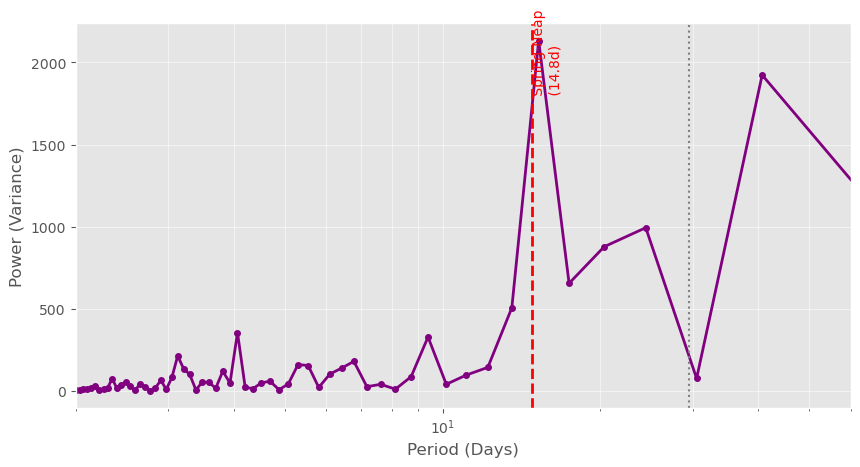

In [10]:
# Mode 3 Frequency Analysis (Tidal Signal Detection) and Wind Correlation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# ================= 配置区域 =================
FILE_PC = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Data_PCs/PCA_Decade_TimeSeries_2010_2019.csv'
TARGET_YEAR = 2010
# ===========================================

def analyze_single_year_spectrum():
    print(f"--- 开始处理 {TARGET_YEAR} 年数据 ---")
    
    # 1. 读取数据
    try:
        df = pd.read_csv(FILE_PC)
        # 清理列名空格
        df.columns = df.columns.str.strip()
        
        # 转换日期
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        
        # 排序
        df.sort_index(inplace=True)
        
    except Exception as e:
        print(f"❌ 数据读取挂了: {e}")
        return

    # 2. 截取夏季数据
    start_date = f"{TARGET_YEAR}-06-01"
    end_date = f"{TARGET_YEAR}-09-30"
    
    # 只要 PC_3
    # 注意：使用 .loc 截取时间段
    summer_series = df.loc[start_date:end_date, 'PC_3']
    
    print(f"提取时间段: {start_date} 到 {end_date}")
    print(f"提取数据点数: {len(summer_series)}")
    
    if len(summer_series) < 50:
        print("❌ 数据太少，无法分析！请检查CSV里的日期格式是否正确。")
        print("文件里的前5个日期是:", df.index[:5].values)
        return

    # 3. 预处理 (补全天数，保证时间轴连续)
    # 生成完美的日索引
    perfect_idx = pd.date_range(start_date, end_date, freq='D')
    # Reindex 并插值
    summer_series = summer_series.reindex(perfect_idx)
    summer_series = summer_series.interpolate(method='linear')
    # 填补头尾可能的 NaN
    summer_series = summer_series.fillna(method='bfill').fillna(method='ffill')
    
    print("数据预处理完成，开始计算频谱...")

    # 4. 频谱分析
    # 去趋势 (Detrend): 这一步很重要，去掉长期的季节性上升/下降，只留波动
    data_detrended = signal.detrend(summer_series.values)
    
    # 计算周期图 (Periodogram)
    f, Pxx = signal.periodogram(data_detrended, fs=1.0) # fs=1 代表采样率是一天一次
    
    # 转换为周期 (避免除以0)
    valid_mask = f > 0
    periods = 1.0 / f[valid_mask]
    power = Pxx[valid_mask]

    # 5. 画图
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 5))
    
    ax.plot(periods, power, color='purple', marker='o', markersize=4, linewidth=2)
    
    # 设置 X 轴为对数，方便看短周期
    ax.set_xscale('log')
    # 限制范围：只看 2天 到 60天
    ax.set_xlim(2, 60)
    
    # 标记关键周期：14.8天 (大小潮)
    target_period = 14.8
    ax.axvline(target_period, color='red', linestyle='--', linewidth=2)
    ax.text(target_period, ax.get_ylim()[1]*0.8, ' Spring-Neap\n (14.8d)', color='red', rotation=90)
    
    # 标记：29.5天 (月周期)
    ax.axvline(29.5, color='gray', linestyle=':', linewidth=1.5)
    
    ax.set_xlabel('Period (Days)')
    ax.set_ylabel('Power (Variance)')
    # ax.set_title(f'Mode 3 Spectral Analysis ({TARGET_YEAR} Summer)')
    ax.grid(True, which="both", ls="-", alpha=0.5)

    output_file = f'Mode3_Spectrum.svg'
    plt.savefig(output_file, dpi=150)
    print(f"✅ 图片已保存: {output_file}")
    plt.show()

if __name__ == "__main__":
    analyze_single_year_spectrum()

The third mode (EOF3) accounts for 6.2% of the total variance in summer surface salinity. Although statistically subordinate to the first two modes, EOF3 exhibits a distinct spatial pattern and a robust periodicity that points to a specific physical driver.

Spatially, EOF3 displays a north-south dipole pattern (Fig. Xa). Positive loadings are distinctively concentrated in the Central Strait of Georgia, encompassing the main extent of the Fraser River plume, while negative loadings dominate the Northern Strait. This pattern indicates that a positive phase of Mode 3 corresponds to an increase in surface salinity within the plume region.

To elucidate the driving mechanism, we performed a spectral analysis on the Principal Component (PC3) time series. The power spectrum reveals a dominant, statistically significant peak at a period of ~14.8 days (Fig. Xb). This periodicity aligns perfectly with the spring-neap tidal cycle and is distinct from the variability of wind or river discharge.

Based on these spatiotemporal characteristics, we interpret Mode 3 as the modulation of plume stratification by tidal mixing. During spring tides, intensified tidal currents generate strong vertical mixing, which breaks down the stratification and entrains saline deep water to the surface, thereby increasing surface salinity in the plume region (positive EOF anomaly). Conversely, during neap tides, reduced mixing energy allows the freshwater plume to re-stratify and spread, resulting in lower surface salinity. This mode highlights the critical role of tidal dynamics in regulating the stratification and dispersion of the Fraser River plume on bi-weekly timescales.

--- 开始处理 2010 到 2019 年的夏季数据 ---
共成功合并了 10 年的夏季频谱。
✅ 图片已保存: Mode3_Spectrum_2010_2019_Avg.svg


/tmp/ipykernel_3759558/1928521076.py:51: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  summer_series = summer_series.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')


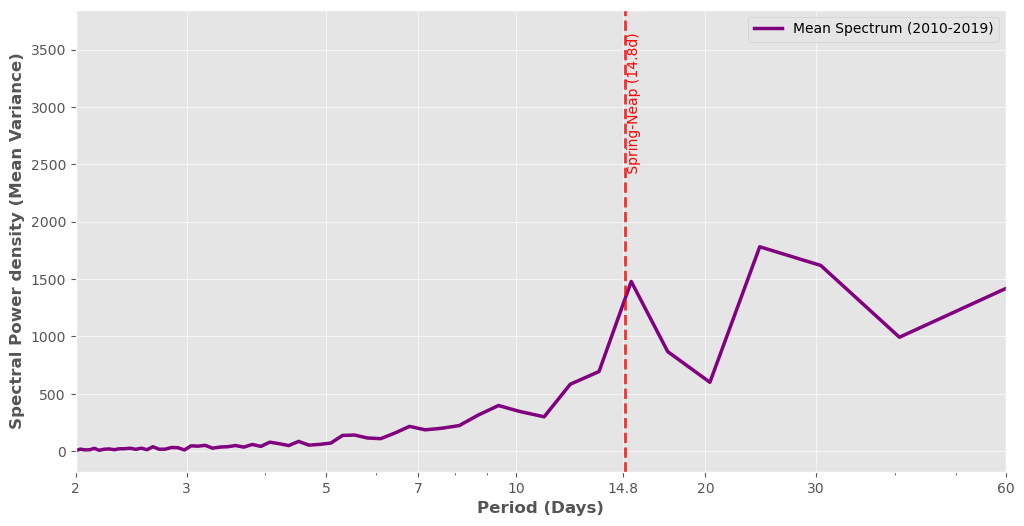

In [4]:
# Mode 3 Frequency Analysis (Tidal Signal Detection) - Multi-Year Average
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.ticker as ticker

# ================= 配置区域 =================
FILE_PC = '/home/jqiu/Programing/Projects/analysis-junqi/Diatom_vs_Flagellate_Report/Data_PCs/PCA_Decade_TimeSeries_2010_2019.csv'
START_YEAR = 2010
END_YEAR = 2019
# ===========================================

def analyze_multi_year_spectrum():
    print(f"--- 开始处理 {START_YEAR} 到 {END_YEAR} 年的夏季数据 ---")
    
    # 1. 读取数据
    try:
        df = pd.read_csv(FILE_PC)
        df.columns = df.columns.str.strip()
        df['Date'] = pd.to_datetime(df['Date'])
        df.set_index('Date', inplace=True)
        df.sort_index(inplace=True)
    except Exception as e:
        print(f"❌ 数据读取挂了: {e}")
        return

    power_list = []
    frequencies = None
    valid_years_count = 0

    # 2. 循环处理每一年的夏季
    for year in range(START_YEAR, END_YEAR + 1):
        start_date = f"{year}-06-01"
        end_date = f"{year}-09-30"
        
        # 提取数据
        summer_series = df.loc[start_date:end_date, 'PC_3']
        
        # 必须保证每年长度一致才能平均。6月-9月通常是122天。
        # 强制生成该年完美的时间索引
        perfect_idx = pd.date_range(start_date, end_date, freq='D')
        
        # 如果原始数据里完全没这个时间段的数据，跳过
        if len(summer_series) < 10:
            print(f"⚠️ {year} 年夏季数据不足，跳过。")
            continue
            
        # Reindex & 插值 (确保每天都有数据，且长度固定)
        summer_series = summer_series.reindex(perfect_idx)
        summer_series = summer_series.interpolate(method='linear').fillna(method='bfill').fillna(method='ffill')
        
        # 去趋势 (Detrend) - 对每年单独去趋势
        data_detrended = signal.detrend(summer_series.values)
        
        # 计算该年的周期图
        # fs=1.0 (每天一个点), nfft设为固定长度以保证频率分辨率一致
        f, Pxx = signal.periodogram(data_detrended, fs=1.0)
        
        # 存储结果
        power_list.append(Pxx)
        if frequencies is None:
            frequencies = f # 只存一次频率轴
        
        valid_years_count += 1

    if valid_years_count == 0:
        print("❌ 没有有效数据可供分析")
        return

    print(f"共成功合并了 {valid_years_count} 年的夏季频谱。")

    # 3. 计算平均频谱 (Averaging Spectra)
    # 将列表转换为矩阵 (Years x Frequencies)，然后沿 Years 轴取平均
    power_matrix = np.array(power_list)
    avg_power = np.mean(power_matrix, axis=0)

    # 转换为周期
    valid_mask = frequencies > 0
    periods = 1.0 / frequencies[valid_mask]
    avg_power_plot = avg_power[valid_mask]

    # 4. 画图
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(12, 6)) #稍微宽一点
    
    # 画线
    ax.plot(periods, avg_power_plot, color='purple', linewidth=2.5, label=f'Mean Spectrum ({START_YEAR}-{END_YEAR})')
    
    # --- 关键修改：自定义 X 轴刻度 ---
    ax.set_xscale('log')
    ax.set_xlim(2, 60) # 限制显示范围
    
    # 设定我们要显示的特定刻度 (Days)
    custom_ticks = [2, 3, 5, 7, 10, 14.8, 20, 30, 60]
    ax.set_xticks(custom_ticks)
    # 将刻度数字转为字符串，14.8 特殊处理一下
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.set_xticklabels([str(t) for t in custom_ticks])

    # 标记关键周期：14.8天 (大小潮)
    target_period = 14.8
    ax.axvline(target_period+0.1, color='red', linestyle='--', linewidth=2, alpha=0.8)
    # 在图上方标注
    ax.text(target_period+0.2, ax.get_ylim()[1]*0.95, ' Spring-Neap (14.8d)', 
            color='red', rotation=90, verticalalignment='top', fontsize=10)
    
    # 标记：29.5天
    # ax.axvline(29.5, color='gray', linestyle=':', linewidth=1.5)
    # ax.text(29.5, ax.get_ylim()[1]*0.6, ' Lunar (29.5d)', color='gray', rotation=90, fontsize=9)

    ax.set_xlabel('Period (Days)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Spectral Power density (Mean Variance)', fontsize=12, fontweight='bold')
    # ax.set_title(f'Mode 3 Spectral Analysis: {START_YEAR}-{END_YEAR} Summer Average', fontsize=14)
    
    ax.grid(True, which="major", ls="-", alpha=0.6, color='white')
    ax.legend()

    output_file = f'Mode3_Spectrum_{START_YEAR}_{END_YEAR}_Avg.svg'
    plt.savefig(output_file, dpi=300)
    print(f"✅ 图片已保存: {output_file}")
    plt.show()

if __name__ == "__main__":
    analyze_multi_year_spectrum()